In [24]:
import os
import numpy as np
import torch
from torch.nn import Linear, MSELoss, BCELoss, ReLU, Dropout, Sequential
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.model_selection import train_test_split
from scipy import sparse
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D plotting)
import random

In [25]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib notebook

In [26]:


# === Dataset Loader ===
class CarGraphDataset(Dataset):
    def __init__(self, root_dir, indices=None):
        self.root_dir = Path(root_dir)
        all_files = sorted([f for f in self.root_dir.rglob("*.npz") if "_adj" not in f.name])
        self.files = [all_files[i] for i in indices] if indices else all_files
        super().__init__()

    def len(self):
        return len(self.files)

    def get(self, idx):
        feat_file = self.files[idx]
        adj_file = feat_file.with_name(feat_file.name.replace(".npz", "_adj.npz"))
        npz_data = np.load(feat_file)

        x = torch.tensor(npz_data["x"], dtype=torch.float32)
        e = torch.tensor(npz_data["e"], dtype=torch.float32)

        a = sparse.load_npz(adj_file).tocoo()
        edge_index = torch.tensor(np.vstack((a.row, a.col)), dtype=torch.long)

        return Data(x=x, edge_index=edge_index, edge_attr=e)


In [27]:

# === Model ===
class GraphAutoEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_dim):
        super().__init__()
        self.encoder = Sequential(
            GCNConv(in_channels, hidden_channels), ReLU(),
            GCNConv(hidden_channels, hidden_channels), ReLU(),
            GCNConv(hidden_channels, hidden_channels), ReLU()
        )
        self.encoder_lin = Sequential(
            Linear(hidden_channels, latent_dim), ReLU(), Dropout(p=0.2))
        self.decoder_lin = Sequential(
            Linear(latent_dim, hidden_channels), ReLU(),
            Linear(hidden_channels, in_channels)
        )

    def encode(self, x, edge_index, batch=None):
        for layer in self.encoder:
            if isinstance(layer, GCNConv):
                x = layer(x, edge_index)
            else:
                x = layer(x)
        z = self.encoder_lin(x)
        if batch is None:
            # If batch is not provided, assume all nodes belong to one graph
            batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        z_graph = global_mean_pool(z, batch)
        return z, z_graph

    def decode(self, z):
        return self.decoder_lin(z)

    def forward(self, x, edge_index, batch=None):
        z, z_graph = self.encode(x, edge_index, batch)
        x_hat = self.decode(z)
        return z, x_hat, z_graph


In [28]:

# === Training loop ===
def run_epoch(model, loader, optimizer, device, train=True):
    model.train() if train else model.eval()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        if train:
            optimizer.zero_grad()

        z, x_hat, z_graph = model(batch.x, batch.edge_index, batch=batch.batch)

        edge_index = batch.edge_index
        z_i = z[edge_index[0]]
        z_j = z[edge_index[1]]
        dot_products = (z_i * z_j).sum(dim=1)
        adj_pred = torch.sigmoid(dot_products)
        adj_true = torch.ones_like(adj_pred)

        loss_x = MSELoss()(x_hat, batch.x)
        loss_a = BCELoss()(adj_pred, adj_true)
        loss = loss_x + loss_a

        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)


In [29]:

# === Visualize original vs reconstructed geometry ===
def plot_reconstruction(model, dataset, device, sample_idx=None):
    model.eval()
    idx = random.choice(range(len(dataset))) if sample_idx is None else sample_idx
    data = dataset[idx].to(device)
    with torch.no_grad():
        z, x_hat, _ = model(data.x, data.edge_index,
                            data.batch if hasattr(data, 'batch') else torch.zeros(data.x.size(0), dtype=torch.long,
                                                                                  device=device))

    x_orig = data.x.cpu().numpy()
    x_recon = x_hat.cpu().numpy()

    plt.figure(figsize=(12, 6))
    for i in range(min(3, x_orig.shape[1])):
        plt.subplot(1, 3, i + 1)
        plt.plot(x_orig[:, i], label='Original', alpha=0.7)
        plt.plot(x_recon[:, i], label='Reconstructed', linestyle='--', alpha=0.7)
        plt.title(f'Feature {i}')
        plt.legend()
    plt.suptitle(f'Reconstruction for sample #{idx}')
    plt.tight_layout()
    plt.savefig("reconstruction_sample.png")
    plt.close()


# === Visualize 2D latent space ===
def plot_latent_space(model, dataset, device):
    model.eval()
    zs = []
    colors = []

    for i, data in enumerate(dataset):
        data = data.to(device)
        batch = torch.zeros(data.x.size(0), dtype=torch.long, device=device)  # if no batch attr
        with torch.no_grad():
            _, _, z_graph = model(data.x, data.edge_index, batch)
        zs.append(z_graph.squeeze(0).cpu().numpy())
        colors.append(i)

    zs = np.array(zs)
    pca = PCA(n_components=2)
    zs_2d = pca.fit_transform(zs)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(zs_2d[:, 0], zs_2d[:, 1], c=colors, cmap='viridis', s=40, edgecolor='k')
    plt.colorbar(scatter, label="Graph index")
    plt.title("2D PCA of Graph-Level Latent Embeddings")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.savefig("latent_projection.png")
    plt.close()



def plot_geometry_comparison(x_orig_np, x_recon_np, sample_idx=None):
    fig = plt.figure(figsize=(12, 6))

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.scatter(x_orig_np[:, 0], x_orig_np[:, 1], x_orig_np[:, 2],
                c='blue', s=3, label='Original')
    ax1.set_title("Original Geometry")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.scatter(x_recon_np[:, 0], x_recon_np[:, 1], x_recon_np[:, 2],
                c='red', s=3, label='Reconstructed')
    ax2.set_title("Reconstructed Geometry")
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")
    ax2.set_zlabel("Z")

    fig.suptitle(f"Sample #{sample_idx} - Original vs Reconstructed Geometry")
    plt.tight_layout()
    plt.savefig(f"geometry_comparison_{sample_idx}.png")
    plt.show()

def plot_losses(train_losses, val_losses):
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(train_losses, label="Train Loss")
    ax.plot(val_losses, label="Val Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Training and Validation Loss")
    ax.grid(True)
    ax.legend()
    display(fig)
    plt.close(fig)


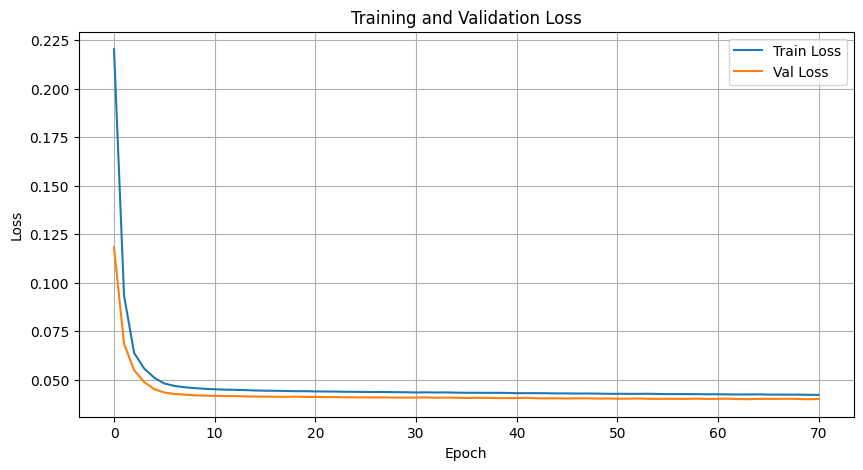

KeyboardInterrupt: 

In [30]:

#%matplotlib inline
# === Main execution ===
path = "/Users/koutsavd/PycharmProjects/Geometry_GNN/Graphs"
all_indices = list(range(len(list(Path(path).rglob("*[!_adj].npz")))))
train_idx, valtest_idx = train_test_split(all_indices, test_size=0.3, random_state=42)
val_idx, test_idx = train_test_split(valtest_idx, test_size=0.5, random_state=42)

train_set = CarGraphDataset(path, indices=train_idx)
val_set = CarGraphDataset(path, indices=val_idx)
test_set = CarGraphDataset(path, indices=test_idx)

train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=8)
test_loader = DataLoader(test_set, batch_size=8)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GraphAutoEncoder(in_channels=8, hidden_channels=64, latent_dim=256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

writer = SummaryWriter(log_dir="runs/graph_ae")
best_val_loss = float("inf")
os.makedirs("checkpoints", exist_ok=True)

train_losses = []
val_losses = []

for epoch in range(1, 101):
    train_loss = run_epoch(model, train_loader, optimizer, device, train=True)
    val_loss = run_epoch(model, val_loader, optimizer, device, train=False)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    writer.add_scalars("Loss", {"train": train_loss, "val": val_loss}, epoch)
    print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    plot_losses(train_losses, val_losses)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "checkpoints/best_model.pt")



In [ ]:

    # === Test ===
    model.load_state_dict(torch.load("checkpoints/best_model.pt"))
    test_loss = run_epoch(model, test_loader, optimizer, device, train=False)
    print(f"Final Test Loss: {test_loss:.4f}")

    # === Visualizations ===
    plot_latent_space(model, test_set, device)
    plot_reconstruction(model, test_set, device)
    # === Visualize full geometry ===
    sample_idx = 5  # Or None for random
    data = test_set[sample_idx].to(device)
    model.eval()
    with torch.no_grad():
        _, x_hat, _ = model(data.x, data.edge_index)

    x_orig_np = data.x[:, :3].cpu().numpy()
    x_recon_np = x_hat[:, :3].cpu().numpy()

    plot_geometry_comparison(x_orig_np, x_recon_np, sample_idx)
